In [1]:
import torch 
import numpy as np
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter

from collections import OrderedDict
from collections import namedtuple
from itertools import product
import time
import pandas as pd
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
torch.__version__

'1.13.1'

In [3]:
torch.cuda.is_available()

True

In [4]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 950


In [5]:
device = torch.device("cuda:0")
device


device(type='cuda', index=0)

In [6]:
print(torch.cuda.device_count())

1


Pepare Data(ETL Process)

In [7]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train= True                        #Extraction 
    ,download=True
    ,transform = transforms.Compose([
        transforms.ToTensor()           #Transform
    ])
)

In [8]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1000) #Load

In [9]:

torch.set_printoptions(linewidth=120)

In [10]:
len(train_set) # to check how many images are in the training set  

60000

In [11]:
train_set.targets # gives the lable tensor

tensor([9, 0, 0,  ..., 3, 0, 5])

In [12]:
train_set.targets.bincount() # This dataset is balanced because the sample size is uniform

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [13]:
sample = next(iter(train_set)) #returns an object stream of data next function for next data element, single sample  

In [14]:
len(sample) #sample contain two items 

2

In [15]:
type(sample)

tuple

In [16]:
image,label = sample #sequence unpacking replace image = sample[0], label = sample[1]

In [17]:
image.shape #1 because single color channel 28 and 28 for hieght and width 

torch.Size([1, 28, 28])

label 9


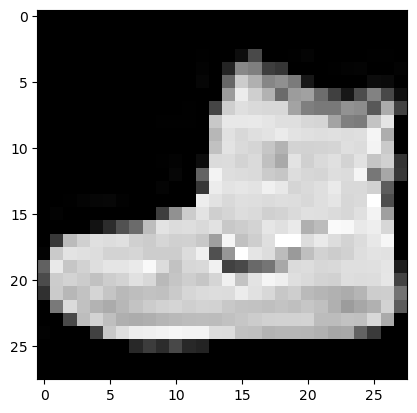

In [18]:
plt.imshow(image.squeeze(),cmap='gray')
print("label",label)

In [19]:
batch = next(iter(train_loader))

In [20]:
len(batch)

2

In [21]:
type(batch)

list

In [22]:
images,labels = batch

In [23]:
images.shape #1000 images with 1 color channel with height of 28 and width of 28

torch.Size([1000, 1, 28, 28])

In [24]:
labels.shape

torch.Size([1000])

In [ ]:
grid = torchvision.utils.make_grid(images,nrow=5) # function to make grid using torchvision make grid

plt.figure(figsize=(6,6))  
plt.imshow(np.transpose(grid,(1,2,0)))

print("labels:",labels)

Build The Model 

In [26]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5) #convolutional layer 1
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12, kernel_size=5) #convolutional layer 2

        self.fc1 =  nn.Linear(in_features=12*4*4, out_features=120) #fully connected layer 1
        self.fc2 = nn.Linear(in_features=120,out_features=60) #fully connected layer 2
        self.out = nn.Linear(in_features=60,out_features=10) # output layer 


    def forward(self,t):
        # (1) input layer
        t = t
        
        #(2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)   
        t = F.max_pool2d(t,kernel_size = 2,stride=2)
        
        #(3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size =2, stride = 2)

        #(4) hidden liner layer
        t = t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        #(5) hidden liner layer 
        t = self.fc2(t)
        t = F.relu(t)

        #(6) output layer
        t = self.out(t)
        #t = F.softmax(t,dim=1)
        
        return t
  

In [27]:
network = Network()
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

Train The Model

In [28]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1
0.14.1


In [29]:
def get_num_correct(preds,lables):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [30]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=100, shuffle=True)

Training Loop reviwe

In [32]:
class RunBuilder():
    @staticmethod
    def get_run(params):

        Run = namedtuple('Run',params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs
    

In [33]:
class RunManager():
    def __init__(self):

        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        self.network = None
        self.loader = None
        self.tb = None

    def begin_run(self,run,network,loader):
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1

        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')

        images,labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)

        self.tb.add_image('images',grid)
        self.tb.add_graph(
            self.network
            ,image.to(getattr(run,'device','cpu'))
        )
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):

        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct/ len(self.loader.dataset)

        self.tb.add_scalar('Loss',loss,self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy,self.epoch_count)

        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param,self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad,self.epoch_count)

        results = OrderedDict()
        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['accuracy'] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k,v in self.run_params._asdict().items():results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data,orient='columns')

        clear_output(wait=True)
        display(df)

    def track_loss(self,loss):
        self.epoch_loss += loss.item() * self.loader.batch_size
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
    
    @torch.no_grad()
    def _get_num_correct(self,preds,labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    def save(self, fileName):

        pd.DataFrame.from_dict(
            self.run_data
            ,orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json','w',encoding='utf-8') as f:
            json.dump(self.run_data,f,ensure_ascii=False,indent = 4)
        


Data Normalization

In [34]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform= transforms.Compose([
        transforms.ToTensor()
    ])
)

In [35]:
loader = DataLoader(train_set,batch_size=len(train_set),num_workers=1)
data =  next(iter(loader))
mean = data[0].mean()
std =  data[0].std()
print('mean:',mean,'std:',std)

mean: tensor(0.2860) std: tensor(0.3530)


In [36]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform= transforms.Compose([
        transforms.ToTensor()
        ,transforms.Normalize(mean,std)
    ])
)

In [37]:
loader = DataLoader(train_set_normal,batch_size=len(train_set),num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std()

(tensor(7.4571e-08), tensor(1.))

In [38]:
trainsets = {
    'not_normal': train_set
    ,'normal': train_set_normal
}

In [40]:
params = OrderedDict(
    lr = [.01]
    ,batch_size =[100,1000]
    ,num_workers= [0,1,2,4,8,16]
    ,device = ['cpu','cuda']
    ,train_set = ['normal']
)

m = RunManager()

for run in RunBuilder.get_run(params):

    device = torch.device(run.device)
    network = Network().to(device)
    loader = DataLoader(train_set, batch_size=run.batch_size)
    optimizer =  optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run,network,loader)
    for epoch in range(1):
        m.begin_epoch()

        for batch in loader:# get batch

            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images) # Pass Batch
            loss =  F.cross_entropy(preds,labels) #calculate loss
            optimizer.zero_grad()
            loss.backward() #calculate Gradients
            optimizer.step() #Update Weights

            m.track_loss(loss)
            m.track_num_correct(preds,labels)
        m.end_epoch()
    m.end_run()
m.save('reults')


,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,train_set
0,1,1,0.589945,0.776717,20.431001,20.709001,0.01,100,0,cpu,normal
1,2,1,0.552315,0.790483,12.847612,13.066616,0.01,100,0,cuda,normal
2,3,1,0.587680,0.778333,20.912001,21.104999,0.01,100,1,cpu,normal
3,4,1,0.582374,0.780833,13.070002,13.275003,0.01,100,1,cuda,normal
4,5,1,0.572295,0.783333,20.425999,20.647999,0.01,100,2,cpu,normal
5,6,1,0.550609,0.791717,13.565002,13.768001,0.01,100,2,cuda,normal
6,7,1,0.593473,0.773700,20.220002,20.416004,0.01,100,4,cpu,normal
7,8,1,0.569639,0.786067,12.086731,12.305730,0.01,100,4,cuda,normal
8,9,1,0.590047,0.779067,20.819000,21.014000,0.01,100,8,cpu,normal
9,10,1,0.597352,0.773267,12.467984,12.647982,0.01,100,8,cuda,normal


In [41]:
pd.DataFrame.from_dict(m.run_data,orient='columns').sort_values('epoch duration')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,train_set
13,14,1,1.115595,0.578033,9.930711,10.722712,0.01,1000,0,cuda,normal
19,20,1,1.098561,0.575333,10.009928,10.789928,0.01,1000,4,cuda,normal
15,16,1,0.929167,0.638950,10.235604,10.984617,0.01,1000,1,cuda,normal
17,18,1,1.063679,0.599183,10.260316,11.051315,0.01,1000,2,cuda,normal
21,22,1,0.967495,0.631183,10.841830,11.648829,0.01,1000,8,cuda,normal
7,8,1,0.569639,0.786067,12.086731,12.305730,0.01,100,4,cuda,normal
23,24,1,0.949336,0.633933,12.244434,13.064446,0.01,1000,16,cuda,normal
11,12,1,0.621936,0.758017,12.316429,12.525429,0.01,100,16,cuda,normal
9,10,1,0.597352,0.773267,12.467984,12.647982,0.01,100,8,cuda,normal
1,2,1,0.552315,0.790483,12.847612,13.066616,0.01,100,0,cuda,normal


In [42]:
pd.DataFrame.from_dict(m.run_data,orient='columns').sort_values('accuracy', ascending=False)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,train_set
5,6,1,0.550609,0.791717,13.565002,13.768001,0.01,100,2,cuda,normal
1,2,1,0.552315,0.790483,12.847612,13.066616,0.01,100,0,cuda,normal
7,8,1,0.569639,0.786067,12.086731,12.305730,0.01,100,4,cuda,normal
4,5,1,0.572295,0.783333,20.425999,20.647999,0.01,100,2,cpu,normal
10,11,1,0.581142,0.781600,20.631997,20.827998,0.01,100,16,cpu,normal
3,4,1,0.582374,0.780833,13.070002,13.275003,0.01,100,1,cuda,normal
8,9,1,0.590047,0.779067,20.819000,21.014000,0.01,100,8,cpu,normal
2,3,1,0.587680,0.778333,20.912001,21.104999,0.01,100,1,cpu,normal
0,1,1,0.589945,0.776717,20.431001,20.709001,0.01,100,0,cpu,normal
6,7,1,0.593473,0.773700,20.220002,20.416004,0.01,100,4,cpu,normal
